# 1. Dataloader

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import onnx, onnxruntime
import matplotlib.pyplot as plt

batch_size = 128

def get_dataloader(train, batch_size, num_workers=2):
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(0.5, 0.5)])
    dataset = torchvision.datasets.MNIST(root='./data',
                                         train=train,
                                         download=True,
                                         transform=transform)
    return torch.utils.data.DataLoader(dataset,
                                       batch_size=batch_size,
                                       shuffle=train,
                                       num_workers=num_workers)


trainloader = get_dataloader(train=True, batch_size=batch_size, num_workers=8)
testloader = get_dataloader(train=False, batch_size=batch_size, num_workers=8)

images, labels = next(iter(trainloader))

# 2. Model

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2)
        self.relu2 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.25)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2304, 512)
        self.relu3 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.dropout1(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        
        return x

device = 'mps'
model = CustomCNN()
model.to(device);

# 3. Training

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
epochs = 10

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.detach().item()
        if (i + 1) % 100 == 0:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

[1,   100] loss: 0.073
[1,   200] loss: 0.027
[1,   300] loss: 0.019
[1,   400] loss: 0.016
[2,   100] loss: 0.012
[2,   200] loss: 0.011
[2,   300] loss: 0.010
[2,   400] loss: 0.009
[3,   100] loss: 0.008
[3,   200] loss: 0.007
[3,   300] loss: 0.007
[3,   400] loss: 0.006
[4,   100] loss: 0.006
[4,   200] loss: 0.005
[4,   300] loss: 0.005
[4,   400] loss: 0.005
[5,   100] loss: 0.005
[5,   200] loss: 0.004
[5,   300] loss: 0.004
[5,   400] loss: 0.004
[6,   100] loss: 0.004
[6,   200] loss: 0.004
[6,   300] loss: 0.004
[6,   400] loss: 0.004
[7,   100] loss: 0.003
[7,   200] loss: 0.004
[7,   300] loss: 0.003
[7,   400] loss: 0.003
[8,   100] loss: 0.003
[8,   200] loss: 0.003
[8,   300] loss: 0.003
[8,   400] loss: 0.003
[9,   100] loss: 0.003
[9,   200] loss: 0.003
[9,   300] loss: 0.003
[9,   400] loss: 0.003
[10,   100] loss: 0.003
[10,   200] loss: 0.003
[10,   300] loss: 0.002
[10,   400] loss: 0.003


# 4. Evaluation

In [43]:
correct = 0
total = 0
model.to(device)
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

assert correct / total >= 0.98
print(f'Test accuracy: {100 * correct // total} %')

Test accuracy: 98 %


# 5. Model dump

In [44]:
torch.save(model.state_dict(), './logs/test_model.pth')

# 6. Model loading

In [182]:
model = CustomCNN()
model.load_state_dict(torch.load('./logs/test_model.pth', weights_only=True))
model.to('cpu');

# 7. Model ONNx export

To prepare the model for later quantization, some layers are fused before exportation.

In [211]:
def group_layers(model):
    grouped_layers = []
    prev_layer = None
    prev_name = None

    for module_name, module in model.named_children():
        layer_name = module.__class__.__name__

        if prev_layer:
            # Conv2d or Linear followed by an Activation
            if prev_layer in {"Conv2d", "Linear"} and layer_name in {"ReLU", "LeakyReLU", "Sigmoid", "Tanh"}:
                grouped_layers.append([prev_name, module_name])
                prev_layer, prev_name = None, None  # Reset

            # Conv2d followed by Normalization
            elif prev_layer == "Conv2d" and layer_name in {"BatchNorm2d", "LayerNorm", "InstanceNorm2d"}:
                prev_layer, prev_name = layer_name, module_name  # Store temporarily

            # Normalization followed by Activation
            elif prev_layer in {"BatchNorm2d", "LayerNorm", "InstanceNorm2d"} and layer_name in {"ReLU", "LeakyReLU", "Sigmoid", "Tanh"}:
                grouped_layers.append([prev_name, module_name])
                prev_layer, prev_name = None, None  # Reset

            else:
                prev_layer, prev_name = layer_name, module_name  # Move to next layer
        else:
            prev_layer, prev_name = layer_name, module_name  # Initialize

    return grouped_layers

grouped_layers = group_layers(model)
fused_model = torch.quantization.fuse_modules(
    model,
    grouped_layers
)

In [202]:
tensor_x = torch.randn((1, 1, 28, 28))
onnx_program = torch.onnx.export(
                    fused_model, 
                    (tensor_x,), 
                    dynamo=True,
                    export_params=True,        
                    opset_version=18,          
                    do_constant_folding=True,  
                    input_names = ['input'],                          
                    output_names = ['output'],
                )
onnx_program.save("./exports/mnist.onnx");


[torch.onnx] Obtain model graph for `CustomCNN([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `CustomCNN([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


# 8. Model quantization

For better quantization, we fuse some of the layers first.
ONNx model should also be pre-processed before quantization with : 

```bash
python -m onnxruntime.quantization.preprocess --input ./exports/mnist.onnx --output ./exports/mnist-infer.onnx
```

Quantization requires tensor shape information to perform its best. Model optimization also improve the performance of quantization. For instance, a Convolution node followed by a BatchNormalization node can be merged into a single node during optimization. Currently we can not quantize BatchNormalization by itself, but we can quantize the merged Convolution + BatchNormalization node. Pre-processing is doing just that.

After this step, we create a calibration dataset to perform static quantization.

In [214]:
from onnxruntime.quantization import quant_pre_process

input_model = "./exports/mnist.onnx"
output_model = "./exports/mnist-infer.onnx"

quant_pre_process(input_model, output_model)

In [159]:
import onnx, onnxruntime
from onnxruntime.quantization import quantize_static, CalibrationDataReader, QuantFormat

model_path = "./exports/mnist-infer.onnx"
quantized_model_path = "./exports/mnist-quantized.onnx"

class MNISTDataReader(CalibrationDataReader):
    def __init__(self, data_folder, num_samples=100):
        self.num_samples = num_samples
        self.data_folder = data_folder
        self.preprocess_flag = True
        self.enum_data_dicts = []
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.load_data()

    def load_data(self):
        dataset = torchvision.datasets.MNIST(root=self.data_folder, train=True, transform=self.transform, download=True)
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

        batch_data = []
        for i, (img, _) in enumerate(data_loader):
            if i >= self.num_samples:
                break
            batch_data.append(img.numpy())

        self.enum_data_dicts = iter([{"input": img} for img in batch_data])

    def get_next(self):
        return next(self.enum_data_dicts, None)

calibration_data_folder = "./data"
calibration_dataset = MNISTDataReader(calibration_data_folder, num_samples=100)

In [160]:
import os

quantize_static(
    model_path,
    quantized_model_path,
    calibration_dataset,
    quant_format=QuantFormat.QDQ
)

print(f"Original ONNX model size (MB): {os.path.getsize(model_path) / (1024 * 1024):.2f}")
print(f"Quantized ONNX model size (MB): {os.path.getsize(quantized_model_path) / (1024 * 1024):.2f}")
print(f"Quantized model saved to {quantized_model_path}")

Original ONNX model size (MB): 4.60
Quantized ONNX model size (MB): 1.16
Quantized model saved to ./exports/mnist-quantized.onnx


In [161]:
quantized_model = onnx.load(quantized_model_path)
print(onnx.helper.printable_graph(quantized_model.graph))

graph main_graph (
  %input[FLOAT, 1x1x28x28]
) initializers (
  %val_3[INT64, 2]
  %input_zero_point[INT8, scalar]
  %input_scale[FLOAT, scalar]
  %conv1.0.weight_zero_point[INT8, scalar]
  %conv1.0.weight_scale[FLOAT, scalar]
  %conv1.0.weight_quantized[INT8, 32x1x5x5]
  %relu_zero_point[INT8, scalar]
  %relu_scale[FLOAT, scalar]
  %conv2.0.weight_zero_point[INT8, scalar]
  %conv2.0.weight_scale[FLOAT, scalar]
  %conv2.0.weight_quantized[INT8, 64x32x3x3]
  %relu_1_zero_point[INT8, scalar]
  %relu_1_scale[FLOAT, scalar]
  %fc1.0.weight_zero_point[INT8, scalar]
  %fc1.0.weight_scale[FLOAT, scalar]
  %fc1.0.weight_quantized[INT8, 512x2304]
  %relu_2_zero_point[INT8, scalar]
  %relu_2_scale[FLOAT, scalar]
  %output_zero_point[INT8, scalar]
  %output_scale[FLOAT, scalar]
  %fc2.weight_zero_point[INT8, scalar]
  %fc2.weight_scale[FLOAT, scalar]
  %fc2.weight_quantized[INT8, 10x512]
  %conv1.0.bias_quantized[INT32, 32]
  %conv1.0.bias_quantized_scale[FLOAT, 1]
  %conv1.0.bias_quantized_zero

# 9. Run quantized model

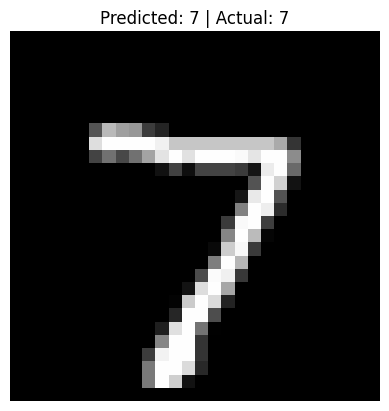

In [2]:
import numpy as np
model_path = "./exports/mnist.onnx"
quantized_model_path = "./exports/mnist-quantized.onnx"

session = onnxruntime.InferenceSession(quantized_model_path, providers=["CPUExecutionProvider"])

transform = transforms.Compose([transforms.ToTensor()])
mnist_test = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

image, label = mnist_test[0]
image_np = image.numpy().astype(np.float32)

input_tensor = np.expand_dims(image_np, axis=0)

input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
output = session.run([output_name], {input_name: input_tensor})[0]
predicted_label = np.argmax(output, axis=1)[0]

plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"Predicted: {predicted_label} | Actual: {label}")
plt.axis("off")
plt.show()

# 10. Compare inference speed

In [3]:
import onnxruntime as ort
import numpy as np
import time

model_path = "./exports/mnist.onnx"
quantized_model_path = "./exports/mnist-quantized.onnx"

execution_provider = "MPSExecutionProvider"
non_quantized_session = ort.InferenceSession(model_path,  providers=["CPUExecutionProvider"])
quantized_session = ort.InferenceSession(quantized_model_path,  providers=["CPUExecutionProvider"])
input_name = quantized_session.get_inputs()[0].name
output_name = quantized_session.get_outputs()[0].name

def benchmark_model(session, input_tensor, runs=50):
    times = []
    for _ in range(runs):
        start_time = time.time()
        input_name = session.get_inputs()[0].name
        output_name = session.get_outputs()[0].name
        session.run([output_name], {input_name: input_tensor})[0]
        end_time = time.time()
        times.append(end_time - start_time)
    return np.mean(times) * 1000

image, label = mnist_test[0]
image_np = image.numpy().astype(np.float32)

input_tensor = np.expand_dims(image_np, axis=0)
label_tensor = torch.Tensor([label])
label_tensor = np.expand_dims(label_tensor, axis=0)

non_quantized_time = benchmark_model(non_quantized_session, input_tensor)
quantized_time = benchmark_model(quantized_session, input_tensor)

# Display results
print(f"🟢 Non-Quantized Model Avg Inference Time: {non_quantized_time:.2f} ms")
print(f"🔥 Quantized Model Avg Inference Time: {quantized_time:.2f} ms")
print(f"🚀 Speedup: {non_quantized_time / quantized_time:.2f}x faster with quantization")


🟢 Non-Quantized Model Avg Inference Time: 0.18 ms
🔥 Quantized Model Avg Inference Time: 0.19 ms
🚀 Speedup: 0.94x faster with quantization


In [7]:
from src.utils.quantization import *

data_sample = next(iter(testloader))
model_path = "./exports/mnist.onnx"
quantized_model_path = "./exports/mnist-quantized.onnx"

quantized_session_performance_benchmark(model_path, quantized_model_path, data_sample)

🟢 Non-Quantized Model Avg Inference Time: 0.11 ms | Avg Accuracy: 100.00%
🔥 Quantized Model Avg Inference Time: 0.11 ms | Avg Accuracy: 87.50%
🚀 Speedup: 1.00x faster with quantization


In [ ]:
from src.net.models.unet.vanilla import VanillaUNet

model = VanillaUNet(use_attention=True)

ImportError: cannot import name 'ReconstructionCIFAR10Loader' from 'src.data.loaders.cifar10' (/Users/bniepce/Projects/Research/MRI/Spiking-fastMRI/src/data/loaders/cifar10.py)

In [5]:
import matplotlib.pyplot as plt

noisy, original = next(iter(train_loader))


IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

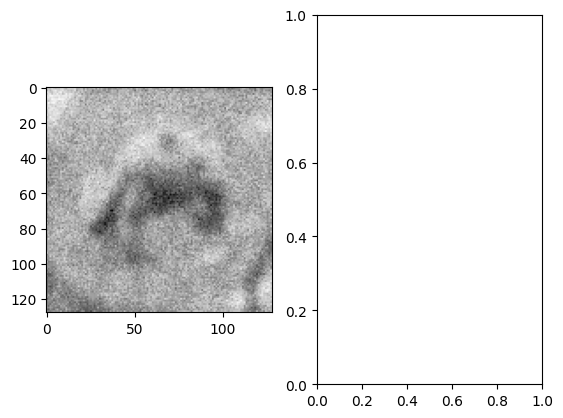

In [6]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(noisy[0][0], cmap='Greys')
axes[1].imshow(original[0][0], cmap='Greys')
plt.show()